# Introduction

In this notebook, I continue from the EDA carried out by Imran. In his notebook, he perfoms some feature analysis as well as some statistical tests to test whether the pollution data displays stationarity. These tests that indicate stationarity are important as this is a very important assumption in Vector Autoregressive (VAR) models.

VAR models are the multivariate generalisation of univariate autoregressive time series models. In general, the prediction vector $y_{t}$ depennds on its $p$ previous values $y_{t-1}, y_{t-2},...,y_{t-p}$. These quantities are related in a linear form as shown below $$y_{t} = a_{0} + \sum_{j=1}^{p}A_{j}y_{t-j} + u_{t}$$
where $y_{t} \in \mathbb{R}^{n}$ vector containing the values of the different time series at time $T=t$, $a_{0} \in \mathbb{R}^{n}$ is a vector of constants, $A_{1} \in \mathbb{R}^{n \times n}$ are the autoregressive coefficients that and $u_{t} \in \mathbb{R}^{n}$ represents noise. 

The ultimate goal is to find the "best" lag $p$ and to fit the ``best" possible autoregressive coefficients. We discuss what is mean by the term "best" in terms of lag and autoregressive coefficients.


First, we just do some preprocessing that was already carried out in the previous notebook.

In [34]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [22]:
with open('../data/raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

In [23]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [24]:
df = df.rename_axis('date').reset_index()

In [25]:
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


## Chosing The Lag $p$

In our model, it is rather pertinent to choose a good value for $p$. By a good value, we mean a value that is long enough such that we can effectively utilise the data we have acquired but not so large such that we creat a model that overfits.

A useful way to see what lag we should use is by plotting autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. These plots tell us how correlated (~ ``predictive") the values at time $T=t-p$ are to values at $T=t$. More specifically, ACF plots show the correlation of a time series with itself at different lags. Alternatively, PACF plots show the correlation of a time series with itself at different lags but without for any correlation between observations of short lags.

Note that as we are working with multiple times series (population, dew, temp, etc), we need to plot ACF and PACF

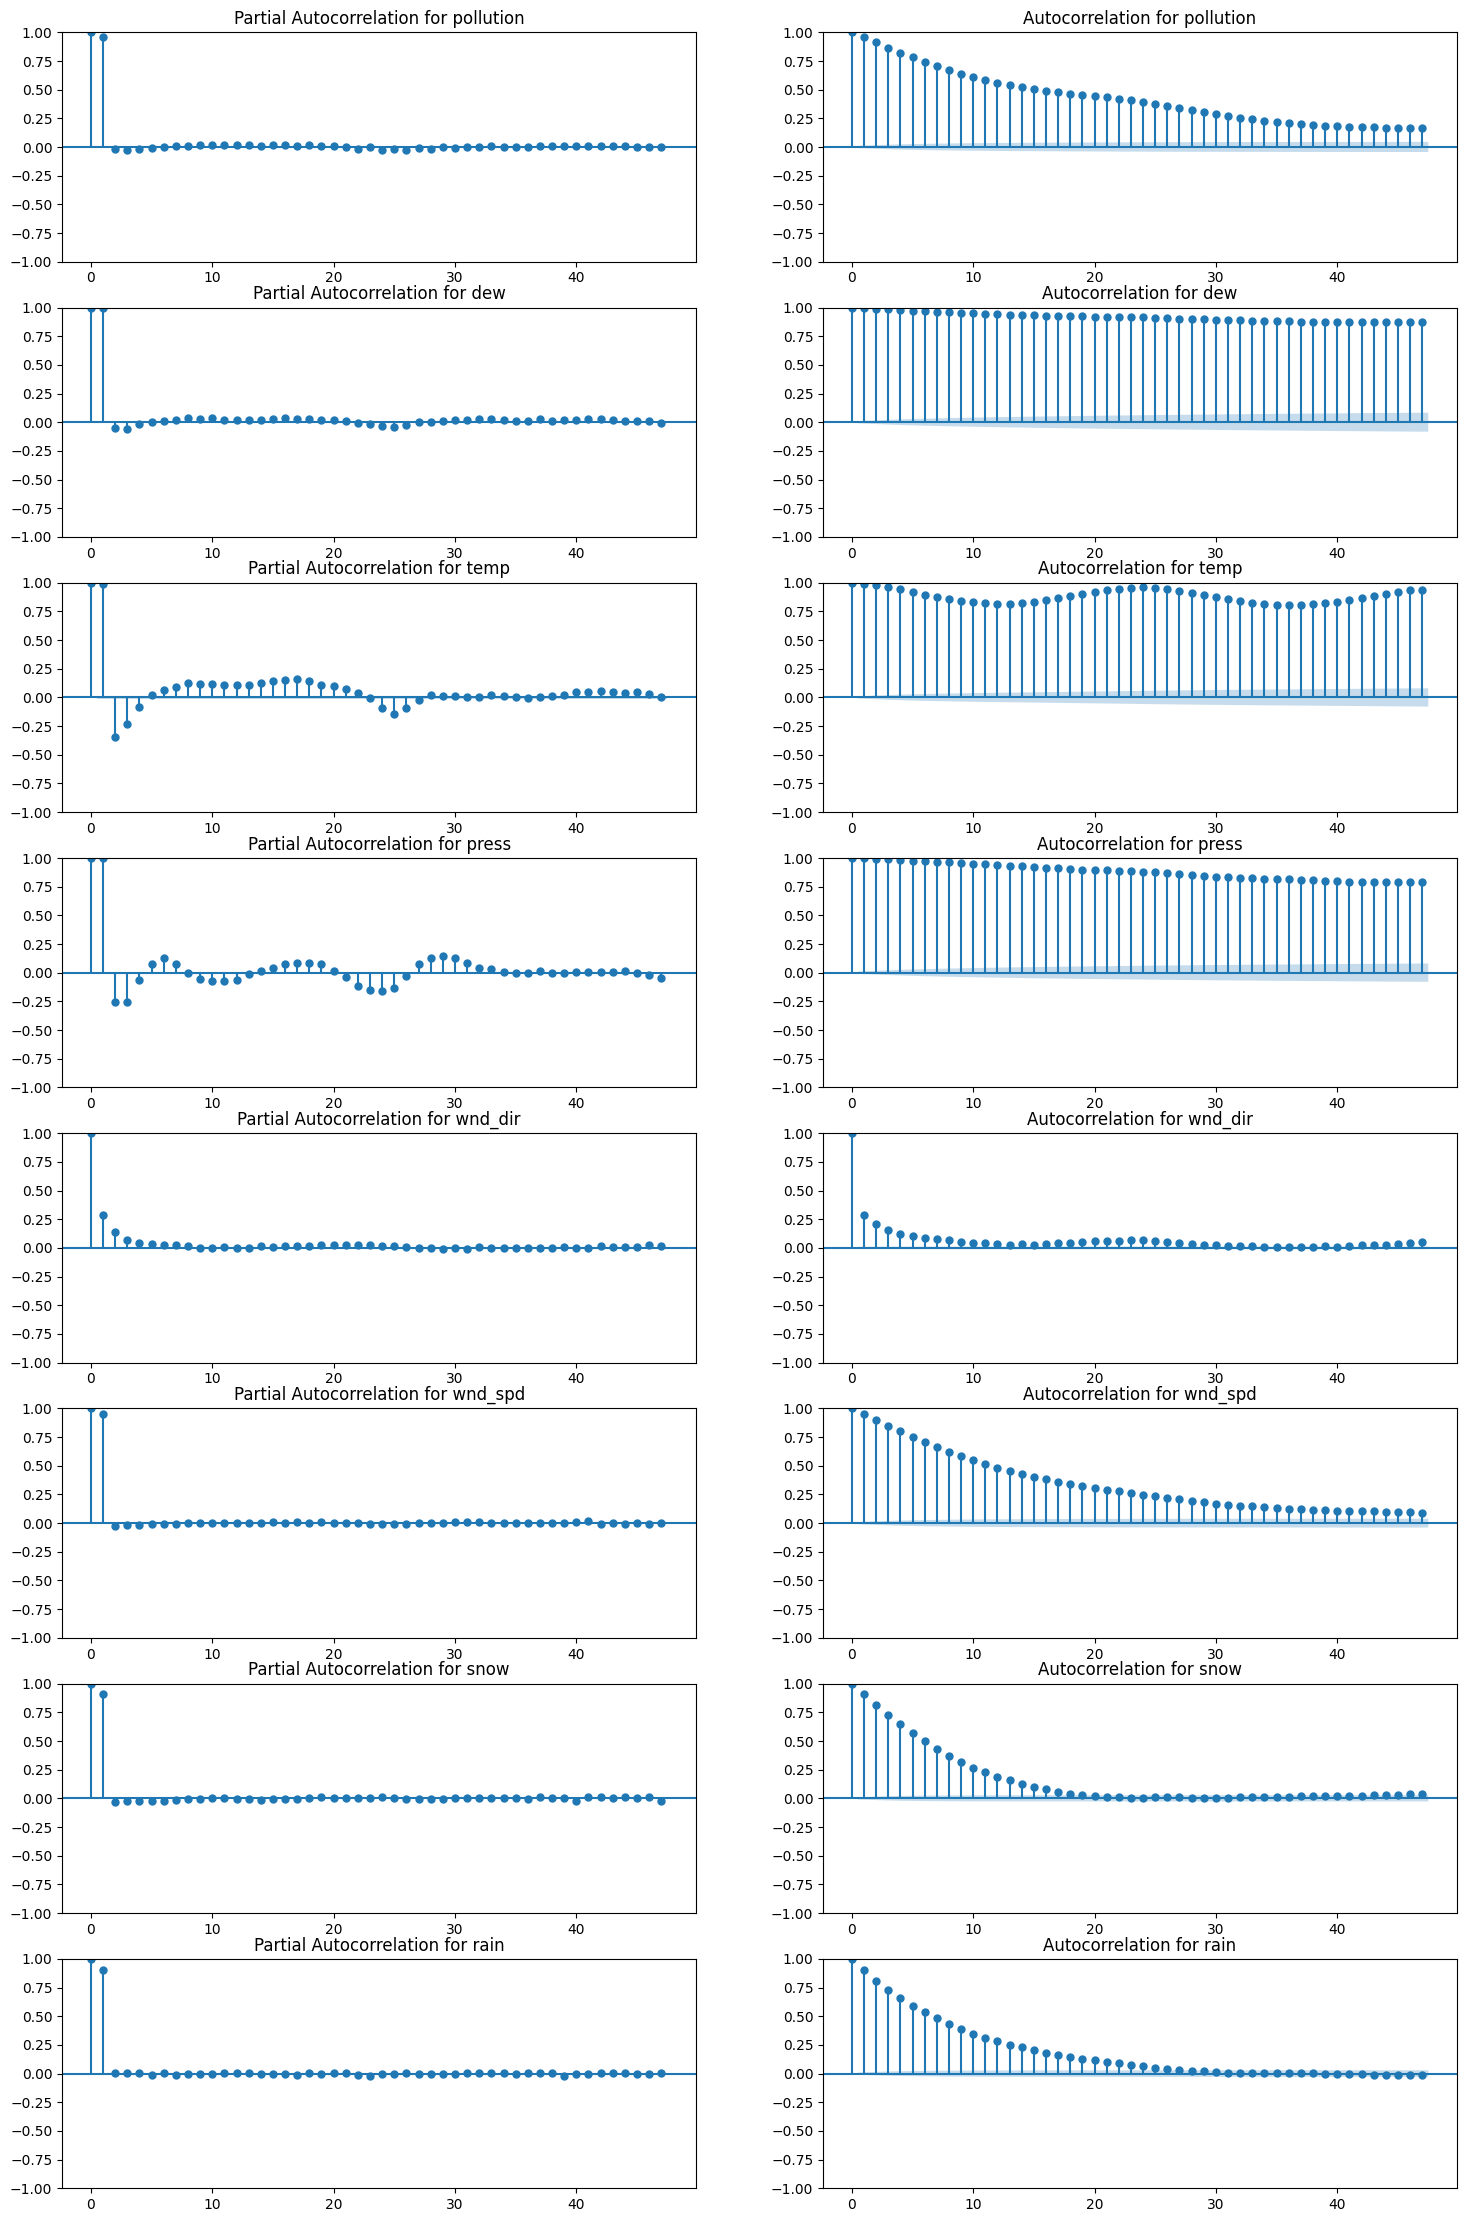

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(18,28))

x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

columns = list(df)
columns.pop(0)
for i, x in enumerate(columns):
    plot_pacf(df[x], axs[i,0], title="Partial Autocorrelation for " + x)
    plot_acf(df[x], axs[i,1], title="Autocorrelation for " + x)

# ANALYSIS
We see that $p$ should be pretty small. We see that there is some seasonal effect for pressure. Maybe we could do some modular arithmetic lag. I am not sure but anyway, after $p=4$, I don't think we have anything significant. #Expand on this

Look up what the context means

# ANALYSIS
We can use information criterion

Watch https://www.youtube.com/watch?v=McEN54l3EPU

Recall that you are reading: https://phdinds-aim.github.io/time_series_handbook/03_VectorAutoregressiveModels/03_VectorAutoregressiveMethods.html#building-a-var-model

## The Granger Causality Test

The Granger causality test